### Fazendo Download dos Arquivos

In [ ]:
!wget -c http://gemeos.org/henrique/selecao_dados.zip -O selecao_dados.zip
!unzip -o selecao_dados.zip

--2021-01-14 17:41:15--  http://gemeos.org/henrique/selecao_dados.zip
Resolving gemeos.org (gemeos.org)... 187.45.195.133
Connecting to gemeos.org (gemeos.org)|187.45.195.133|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  selecao_dados.zip
  inflating: regressao_1.csv         
  inflating: regressao_2.csv         
  inflating: classificacao_1.csv     
  inflating: classificacao_2.csv     
  inflating: agrupamento.csv         
  inflating: centroides_iniciais.csv  


In [ ]:
#Libs gerais
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

#Libs para Clusterizacao
from sklearn.cluster import KMeans


#Libs para classificacao
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier


#Libs para regressão
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold


## Clusterização

### Melhor Agrupamento

Considerando os dados no arquivo agrupamento.csv, execute o algoritmo K-Means tendo como posição inicial dos centroides as K primeiras linhas do arquivo centroides.csv. Por exemplo, para executar o algoritmo com 3 clusters considere que os centroides iniciais são determinados pelas 3 primeiras linhas do arquivo centroides_iniciais.csv. Determine:



a) Qual a quantidade ideal de clusters?

In [ ]:
#Captura o arquivo csv
df = pd.read_csv('agrupamento.csv')

#Apresenta os dados da tabela
df.head()

,V1,V2,V3
0,0.274192,0.205828,0.465012
1,-0.112940,0.182955,0.104824
2,0.072626,-0.000491,0.194147
3,0.126573,0.027202,0.075395
4,0.080854,-0.144031,-0.199187


In [ ]:
#Verifica os initial centroids (Tem 16)
df2 = pd.read_csv('centroides_iniciais.csv')
df2

,V1,V2,V3
0,0.010759,0.150686,0.049970
1,0.911179,-0.010054,-0.093556
2,-0.526115,1.049235,-0.132915
3,0.603327,1.353277,0.159188
4,-0.084500,-0.260496,0.611731
5,1.345370,0.204004,1.050706
6,0.134371,0.893534,1.056753
7,1.010007,0.941614,1.153476
8,-0.167530,-0.030102,-0.103930
9,0.625067,0.077655,0.319642


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  import sys
/usr/local/lib/python3.6/dist-packages/ipyker

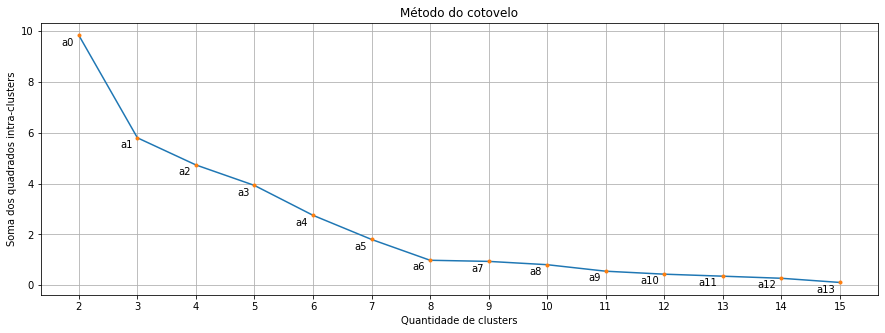

In [ ]:
#Processo de buscar em grade de parâmetros

def calculate_wcss(data):
    wcss = []
    for n in range(2, 16):
        kmeans = KMeans(n_clusters=n, init=df2.iloc[0:n,:])
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss


#Calcula a soma dos quadrados para os 16 clusters
sum_of_squares = calculate_wcss(df2)

#Apresenta o processo de otimização método elbow
plt.figure(figsize=(15,5))
plt.title('Método do cotovelo')
plt.xlabel('Quantidade de clusters')
plt.ylabel('Soma dos quadrados intra-clusters')
plt.grid()
intervalo = range(2,16) 
plt.xticks(intervalo)
plt.plot(intervalo, sum_of_squares) # pontos laranjas
plt.plot(intervalo, sum_of_squares, '.') # linha azul
for x,y in zip(intervalo,sum_of_squares): # colocando nome nos pontos
    label = "a{}".format(x-2)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(-5,-10),
                 ha='right')
plt.show()

In [ ]:
#Calculo da quantidade ótima de clusters
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

quantClusters = optimal_number_of_clusters(sum_of_squares)

### **a) Qual a quantidade ideal de clusters?**

In [ ]:
#Quantidade ótima de clusters (8)
quantClusters

8

In [ ]:
#Executando a aplicação com otimizacao
kmeans = KMeans(n_clusters=quantClusters, init=df2.iloc[0:quantClusters,:])
clusters = kmeans.fit_predict(df)
clusters

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return self.fit(X, sample_weight=sample_weight).labels_


array([0, 0, 0, ..., 7, 7, 7], dtype=int32)

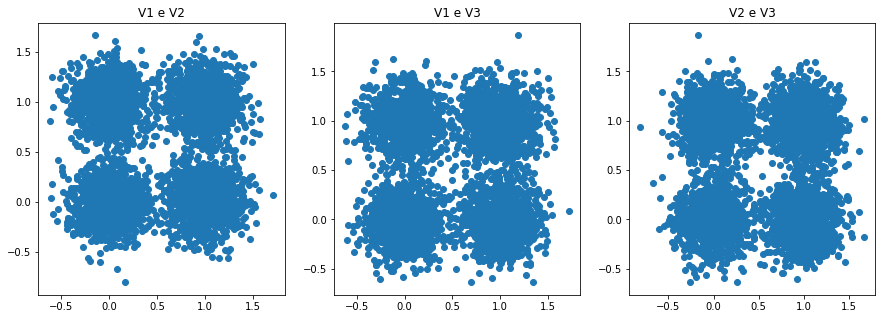

In [ ]:
#Apresentação dos dados
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.title('V1 e V2')
plt.scatter(df['V1'], df['V2'])

plt.subplot(1, 3, 2)
plt.title('V1 e V3')
plt.scatter(df['V1'], df['V3'])

plt.subplot(1, 3, 3)
plt.title('V2 e V3')
plt.scatter(df['V2'], df['V3'])

plt.show()

###Aparentemente tem mais jeito de ser com 4 clusters, porém temos que considerar que os centroids iniciais podem ter modificado a sua forma

### Função de Custo

Considerando os dados no arquivo agrupamento.csv, execute o algoritmo K-Means tendo como posição inicial dos centroides as K primeiras linhas do arquivo centroides.csv. Por exemplo, para executar o algoritmo com 3 clusters considere que os centroides iniciais são determinados pelas 3 primeiras linhas do arquivo centroides_iniciais.csv. Determine:



### **b) Qual o valor final da função de custo sendo minimizada pelo algoritmo K-Means para a quantidade ideal de clusters determinada na questão anterior (a)?**

In [ ]:
sum_of_squares[quantClusters-2]

0.9783656570248415

## Classificação

### Árvore de Decisão Partição de Treino

Considerando os dados do arquivo classificacao_1.csv, treine o modelo Árvore de Decisão (profundidade máxima de 5 níveis): 1) utilizando como metodologia de validação cruzada o k-Fold com k=10 (sequencial, isto é, utilizando a ordem dos dados para gerar as folds). Responda: 

a) Qual é a média da métrica F1 Score nas partições de treino?

In [ ]:
#Captura o arquivo csv
df = pd.read_csv('classificacao_1.csv')

#Apresenta os dados da tabela
print(df.head())

#Excluir valores duplicados
df = df.drop_duplicates(subset=["v_1", "v_2","v_3", "v_4", "v_5", "v_6", "v_7","v_8", "v_9", "v_10","v_11", "v_12", "v_13", "v_14", "v_15", "v_16", "v_17", "v_18"])

#Dimensões do dataset
print(df.shape)

#Verifica as classes de dados
print(np.unique(df['target']))

#Verifica as classes estão balanceadas (48%)
print(sum( df['target'] == 0)/len(df['target']))

#Verifica valores nulos
print(df.isnull().sum())

#Separa 80% para treinamento e 20% para avaliação
train , test = train_test_split(df, test_size = 0.2)

#Separa atributos e rotulos do treinamento
x_train = train.drop('target', axis=1)
y_train = train['target']

#Separa atributos e rotulos do teste
x_test = test.drop('target', axis=1)
y_test = test['target']

#Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

       v_1      v_2      v_3      v_4  ...     v_16     v_17     v_18  target
0 -0.79207 -1.53485  0.60615 -2.27976  ... -2.32598 -2.71869 -1.76932       0
1  0.21583 -0.93657  0.75756  0.37746  ... -2.69853  4.91233  0.09381       0
2 -0.32059 -2.16565 -1.63757  0.79361  ... -3.31448  0.24915  3.10828       0
3 -0.12929 -0.06134  3.58236 -1.48172  ...  3.76759 -3.87927 -0.74953       0
4 -1.85108 -3.65335  0.10311 -0.18259  ...  0.90993 -0.10623 -1.38851       0

[5 rows x 19 columns]
(1250, 19)
[0 1]
0.4784
v_1       0
v_2       0
v_3       0
v_4       0
v_5       0
v_6       0
v_7       0
v_8       0
v_9       0
v_10      0
v_11      0
v_12      0
v_13      0
v_14      0
v_15      0
v_16      0
v_17      0
v_18      0
target    0
dtype: int64


In [ ]:
#Instância o modelo
model = DecisionTreeClassifier(max_depth=5)

#Treino
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#Cross validation do modelo de treino
cv_scores = cross_val_score(model, x_train, y_train, scoring='f1_macro', cv = 10).mean()
cv_scores

0.7694609483800915

### Árvore de Decisão Partições de Teste

Considerando os dados do arquivo classificacao_1.csv, treine o modelo Árvore de Decisão (profundidade máxima de 5 níveis) utilizando como metodologia de validação cruzada o k-Fold com k=10. Responda: 


b) Qual é a média da métrica F1 Score nas partições de validação?

In [ ]:
#Cross validation do modelo de treino
cv_scores = cross_val_score(model, x_test, y_test, scoring='f1_macro', cv = 10).mean()
cv_scores

0.7435837546109285

### Naive Bayes Treino

Considerando os dados do arquivo classificacao_2.csv, treine o modelo Naive Bayes utilizando como metodologia de validação cruzada o k-Fold com k=5 (sequencial, isto é, utilizando a ordem dos dados para gerar as folds). Responda: 



- a) Qual é a média da métrica AUC nas partições de treino?
- b) Qual é a média da métrica AUC nas partições de validação?

In [ ]:
#Captura o arquivo csv
df = pd.read_csv('classificacao_2.csv')

#Apresenta os dados da tabela
print(df.head())

#Excluir valores duplicados
df = df.drop_duplicates(subset=["v_1", "v_2","v_3", "v_4", "v_5", "v_6", "v_7","v_8", "v_9", "v_10","v_11", "v_12"])

#Dimensões do dataset
print(df.shape)

#Verifica as classes de dados
print(np.unique(df['target']))

#Verifica as classes estão balanceadas (68%)
print(sum( df['target'] == 0)/len(df['target']))

#Verifica valores nulos
print(df.isnull().sum())

#Separa 80% para treinamento e 20% para avaliação
train , test = train_test_split(df, test_size = 0.2)

#Separa atributos e rotulos do treinamento
x_train = train.drop('target', axis=1)
y_train = train['target']

#Separa atributos e rotulos do teste
x_test = test.drop('target', axis=1)
y_test = test['target']

#Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

       v_1      v_2      v_3      v_4  ...     v_10     v_11     v_12  target
0 -0.79138 -1.45877 -0.61498  6.39546  ...  2.85597  2.52876  2.09155       0
1  0.79527 -0.14828  0.49140  0.10649  ... -1.11079  3.61077  1.11076       0
2 -2.30926  1.59887  1.23513 -4.49395  ...  1.75719 -1.71703  0.92375       1
3  1.97998 -2.71683 -0.73252  3.08358  ... -1.56391  1.00917  1.66555       0
4 -1.22339  2.38761 -2.15763 -1.91316  ...  0.18525  2.91384 -0.03258       1

[5 rows x 13 columns]
(2500, 13)
[0 1]
0.6896
v_1       0
v_2       0
v_3       0
v_4       0
v_5       0
v_6       0
v_7       0
v_8       0
v_9       0
v_10      0
v_11      0
v_12      0
target    0
dtype: int64


In [ ]:
#Instância o modelo
model = GaussianNB()

#Treino
model.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### **a) Qual é a média da métrica AUC nas partições de treino?**

In [ ]:
#Cross validation do modelo de treino
cv_scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv = 5).mean()
cv_scores

0.8471335172765524

### **b) Qual é a média da métrica AUC nas partições de avaliação?**

In [ ]:
#Cross validation do modelo de avaliação
cv_scores = cross_val_score(model, x_test, y_test, scoring='roc_auc', cv = 5).mean()
cv_scores

0.8872606692045683

## Regressão

Considerando os dados do arquivo regressao_1.csv, treine o modelo KNN (K=100, distância: euclidiana) utilizando como metodologia de validação cruzada o K-Fold com K=5 (sequencial, isto é, utilizando a ordem dos dados para gerar as folds). Responda:



- a) Qual é a média da métrica R² nas partições de treino?
- b) Qual é a média da métrica R² nas partições de validação?

In [ ]:
#Captura o arquivo csv
df = pd.read_csv('regressao_1.csv')

#Apresenta os dados da tabela
df.head()

,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,target
0,0.41175,-0.88594,1.56763,-1.23920,-0.50609,0.40241,-0.19910,-0.36066,0.79811,-1.31550,-0.97004,0.25646,-0.97230,0.57444,0.86559,0.26008,59.426681
1,-0.18248,0.25817,-2.06830,0.30318,0.55240,1.14899,-1.06234,-1.05560,-0.39798,1.07560,0.32977,1.39860,0.13139,1.66229,-1.64970,-1.19903,-124.336003
2,0.16163,-0.19307,0.60995,0.75154,-0.34150,-1.07175,0.82420,-0.70458,0.15541,-0.41075,-0.36719,-0.40403,-1.36095,-0.32300,-1.80617,-2.36065,-135.453843
3,0.77408,-0.22030,-1.50507,0.26270,-0.43915,0.61604,-0.07312,1.05734,0.74734,-0.02001,-0.53163,-0.01862,-1.02064,0.20504,-0.46479,0.51637,15.301539
4,0.56369,-2.03858,1.00566,-0.22191,1.87744,0.92188,1.32863,1.23291,0.64139,-0.51216,-0.11285,1.36791,0.16337,0.17806,-0.79946,0.49963,0.344680


In [ ]:
#Excluir valores duplicados
df = df.drop_duplicates(subset=["v_1", "v_2","v_3", "v_4", "v_5", "v_6", "v_7","v_8", "v_9", "v_10","v_11", "v_12","v_13", "v_14", "v_15", "v_16"])

#Dimensões do dataset
df.shape

(2500, 17)

In [ ]:
#Verifica valores nulos
df.isnull().sum()

v_1       0
v_2       0
v_3       0
v_4       0
v_5       0
v_6       0
v_7       0
v_8       0
v_9       0
v_10      0
v_11      0
v_12      0
v_13      0
v_14      0
v_15      0
v_16      0
target    0
dtype: int64

In [ ]:
#Separa 80% para treinamento e 20% para avaliação
train , test = train_test_split(df, test_size = 0.2)

#Separa atributos e rotulos do treinamento
x_train = train.drop('target', axis=1)
y_train = train['target']

#Separa atributos e rotulos do teste
x_test = test.drop('target', axis=1)
y_test = test['target']


In [ ]:
#Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

In [ ]:
#Definido parâmetros
K = 100      # Número de vizinhos
D = 2        # Manhattan_distance p = 1 and euclidean_distance p = 2)
CV = 5       # Quantidade de folds

#Instância o modelo
model = neighbors.KNeighborsRegressor(n_neighbors = K, p = D)

#Treino
model.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                    weights='uniform')

#### **a) Qual é a média da métrica R² nas partições de treino?**

In [ ]:
#Cross validation do modelo de treino
cv_scores = cross_val_score(model, x_train, y_train, cv = CV, scoring='r2').mean()
cv_scores

0.6200387501676998

#### **b) Qual é a média da métrica R² nas partições de validação?**

In [ ]:
#Cross validation do modelo de teste
cv_scores = cross_val_score(model, x_test, y_test, cv = CV, scoring='r2').mean()
cv_scores

0.4787748630385429

Considerando os dados do arquivo regressão_2.csv, treine o modelo Elastic Net (parâmetro de penalização: 0.01 (alpha no scikit-learn, lambda no glmnet), parâmetro de mistura: 0.5 (l1_ratio no scikit-learn, alpha no glmnet)) utilizando como metodologia de validação cruzada o K-Fold com K=10 (sequencial, isto é, utilizando a ordem dos dados para gerar as folds). Responda:



- a) Qual é a média da métrica MSE nas partições de treino?
- b) Qual é a média da métrica MSE nas partições de validação?

In [ ]:
#Captura o arquivo csv
df = pd.read_csv('regressao_2.csv')

#Apresenta os dados da tabela
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,target
0,0.928565,-0.719700,-0.193906,-0.677486,-1.179784,-0.866473,-0.527861,-0.363196,-0.753120,-1.032732,-1.068407
1,-1.262432,-0.803072,-0.026298,0.070038,-1.223663,0.169027,0.677987,-0.170260,0.332584,0.504562,-0.476471
2,0.117189,0.853866,1.582002,1.481968,1.720371,0.209258,0.148371,1.694372,1.300706,1.236036,-6.258761
3,-0.148722,-0.133637,0.020990,-0.261777,-0.648657,-0.344005,0.689685,0.503188,0.034081,-0.003327,4.029771
4,-1.589064,-1.120601,-2.323954,-1.236945,-0.683011,-0.468862,-0.810920,-2.981145,-3.196629,-0.876743,-18.675821


In [ ]:
#Excluir valores duplicados
df = df.drop_duplicates(subset=["V1", "V2","V3", "V4", "V5", "V6", "V7","V8", "V9", "V10"])

#Dimensões do dataset
df.shape

(1000, 11)

In [ ]:
#Separa 80% para treinamento e 20% para avaliação
train , test = train_test_split(df, test_size = 0.2)

#Separa atributos e rotulos do treinamento
x_train = train.drop('target', axis=1)
y_train = train['target']

#Separa atributos e rotulos do teste
x_test = test.drop('target', axis=1)
y_test = test['target']

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

In [ ]:
#Definido parâmetros

#Instância o modelo
model =  ElasticNet(alpha=0.01, l1_ratio=0.5)

#Treinamento
model.fit(x_train, y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### **a) Qual é a média da métrica MSE nas partições de treino?**


In [ ]:
#Avaliação do modelo
scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=10)
# force scores to be positive

scores = np.absolute(scores)
print('Mean MSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MSE: 8.278 (0.423)


#### **b) Qual é a média da métrica MSE nas partições de validação?**



In [ ]:
#Avaliação do modelo
scores = cross_val_score(model, x_test, y_test, scoring='neg_mean_absolute_error', cv=10)
# force scores to be positive

scores = np.absolute(scores)
print('Mean MSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MSE: 8.242 (1.277)
